In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
# import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.1,
               'scale': 252 * 1.564e-5,
               'delta': 0.6475,
               'rho': .95,
              }
else:
     true_params ={'delta': 0.27,
                   'rho': 0.81,
                   'scale': 3.11,
                   'phi': -.1,
                   'pi': -.2,
                   'theta': .53}
    
time_dim = 37000
sim_dim = 500
innov_dim = 250

In [6]:
vl.__version__

'0.0.13-py36_0'

In [7]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [8]:
def compute_moments(delta, rho, scale, phi, pi, theta):
    
    vol_mean = scale * delta / (1 - rho)
    vol_var = (2 * scale * rho * vol_mean + scale**2 * delta) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, scale=scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, scale=scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(delta=delta, rho=rho, scale=scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [9]:
compute_moments(**true_params)

{'return_mean': -0.058237122739760366,
 'return_var': 0.07937188784373717,
 'vol_mean': 0.051039575999999955,
 'vol_var': 0.004023225201945595}

In [10]:
vl.compute_gamma(**true_params)

0.0030570082011817778

In [11]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.1,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.0030570082011817778,
 'beta': 1.1950867890728585,
 'psi': -2.396000584691815,
 'zeta': 0.99}

In [ ]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.1,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95}

In [ ]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.1,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.0030570082011817778,
 'beta': 1.1950867890728585,
 'psi': -2.396000584691815,
 'zeta': 0.99}

## We start by examining the distributions of simulated data

In [ ]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [ ]:
data.corr()

,vol,rtn
vol,1.000000,-0.348381
rtn,-0.348381,1.000000


In [ ]:
omega, omega_cov = vl.estimate_params(data)

In [ ]:
omega

{'gamma': 0.003092616914858787,
 'beta': 1.1837890442002412,
 'psi': -2.402751819864635,
 'zeta': 0.9999209141430664,
 'delta': 0.6187807155419934,
 'rho': 0.9556184364097029,
 'scale': 0.00388508502940008}

In [ ]:
omega_cov

,beta,delta,gamma,psi,rho,scale,zeta
beta,0.001474,0.000000e+00,-4.051123e-06,-0.001400,0.000000e+00,0.000000e+00,0.000000
delta,0.000000,4.491614e-04,0.000000e+00,0.000000,-3.074092e-05,-1.278382e-07,0.000000
gamma,-0.000004,0.000000e+00,4.088515e-08,0.000003,0.000000e+00,0.000000e+00,0.000000
psi,-0.001400,0.000000e+00,3.296421e-06,0.001838,0.000000e+00,0.000000e+00,0.000000
rho,0.000000,-3.074092e-05,0.000000e+00,0.000000,5.969265e-06,-6.052880e-09,0.000000
scale,0.000000,-1.278382e-07,0.000000e+00,0.000000,-6.052880e-09,2.056615e-09,0.000000
zeta,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000053


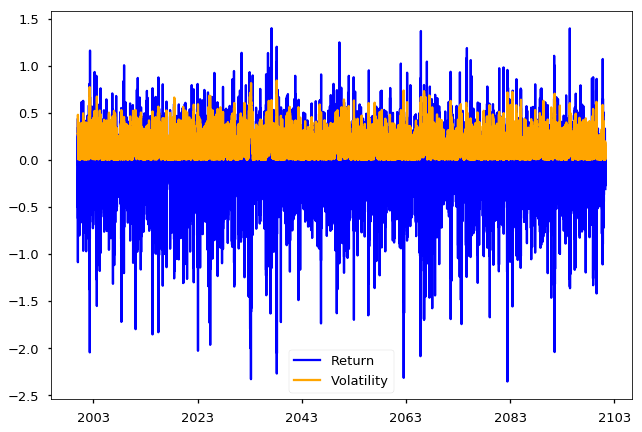

In [ ]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [ ]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.016925,-0.010807
rtn,-0.010807,0.063514


In [ ]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.1,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.0030570082011817778,
 'beta': 1.1950867890728585,
 'psi': -2.396000584691815,
 'zeta': 0.99}

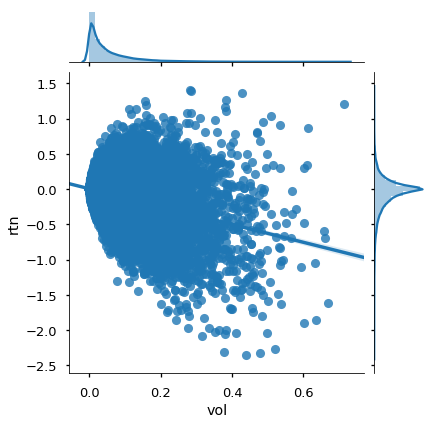

In [ ]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [ ]:
data.describe()

,vol,rtn
count,37000.000000,37000.000000
mean,0.054168,-0.062949
std,0.069435,0.252019
min,0.000010,-2.352430
25%,0.008401,-0.152192
50%,0.028948,-0.018821
75%,0.073115,0.056742
max,0.714548,1.401093


## I now estimate all of the parameters

In [ ]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [ ]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [ ]:
estimator(data_arr[2])

({'gamma': 0.0030408866312912316,
  'beta': 1.204375682310559,
  'psi': -2.397369765337873,
  'zeta': 0.9895293918141882,
  'delta': 0.6538806756300979,
  'rho': 0.9485515027183112,
  'scale': 0.003967853595403344,
  'phi': -0.09625011901848649,
  'pi': -15.684264211727317,
  'theta': 1.8135146938457138},
            beta         delta         gamma       phi           pi       psi  \
 beta   0.001550  0.000000e+00 -3.837941e-06       NaN          NaN -0.001473   
 delta  0.000000  4.475349e-04  0.000000e+00       NaN          NaN  0.000000   
 gamma -0.000004  0.000000e+00  4.056130e-08       NaN          NaN  0.000003   
 phi         NaN           NaN           NaN  0.001383    -1.665461       NaN   
 pi          NaN           NaN           NaN -1.665461  2020.472003       NaN   
 psi   -0.001473  0.000000e+00  3.032864e-06       NaN          NaN  0.001944   
 rho    0.000000 -3.323621e-05  0.000000e+00       NaN          NaN  0.000000   
 scale  0.000000 -1.493810e-07  0.000000e+00 

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

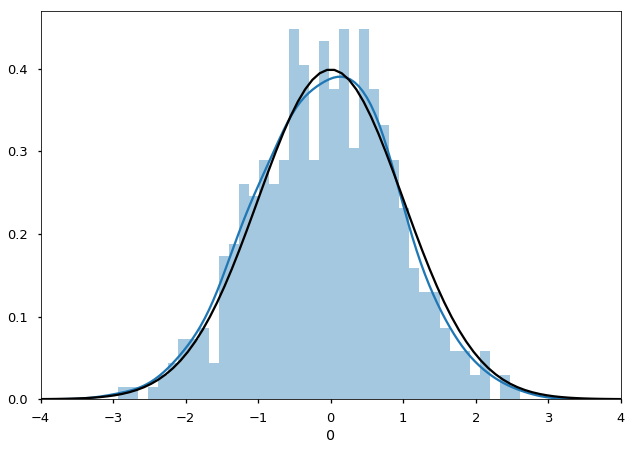

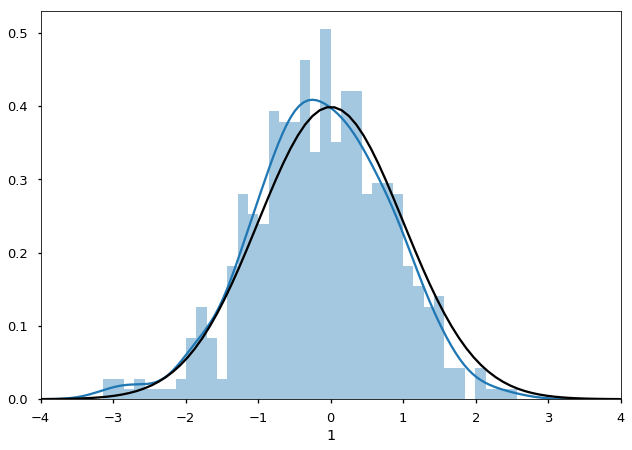

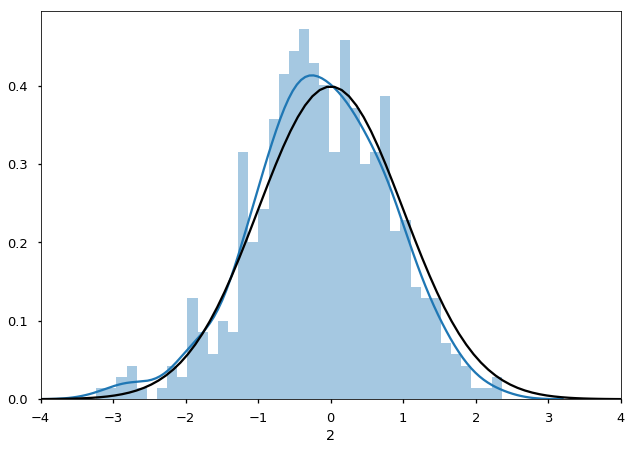

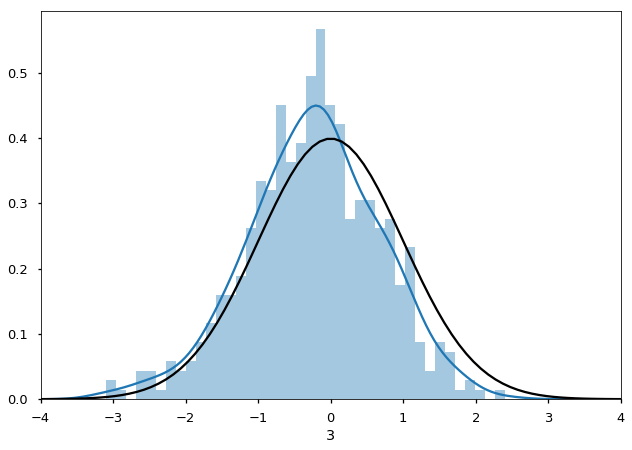

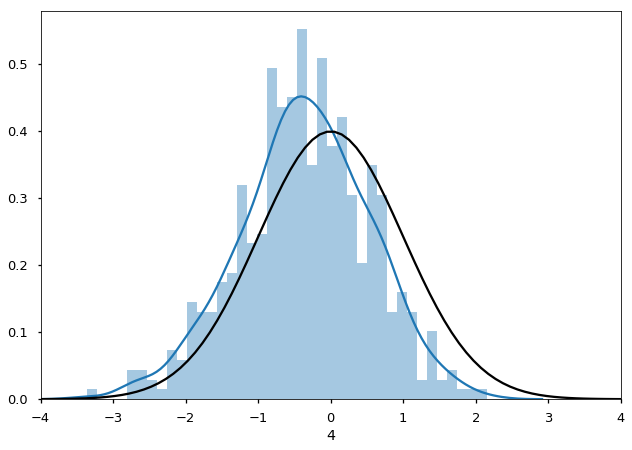

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

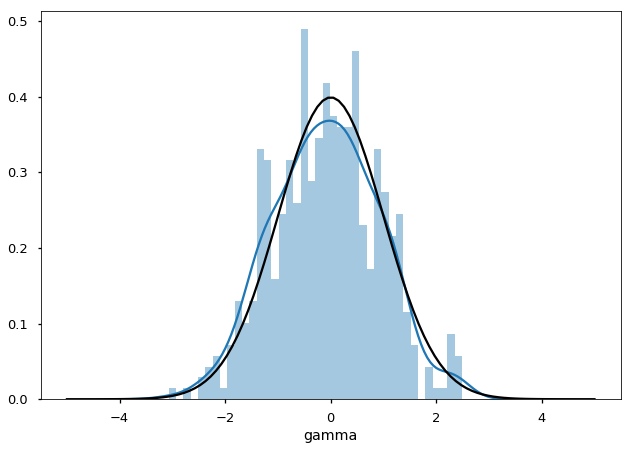

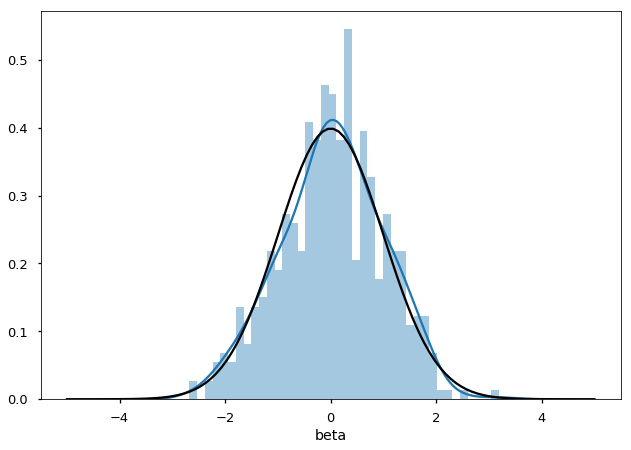

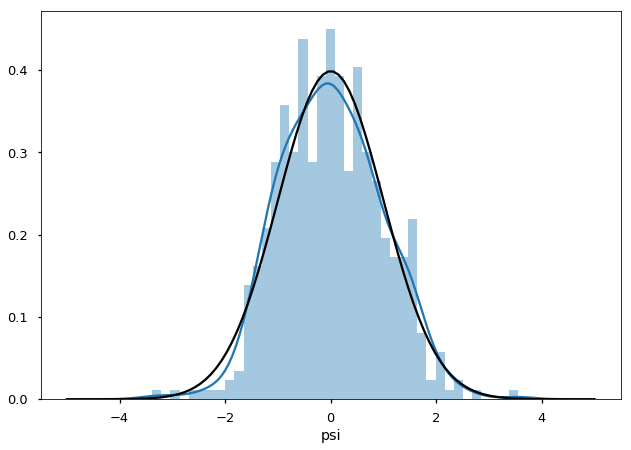

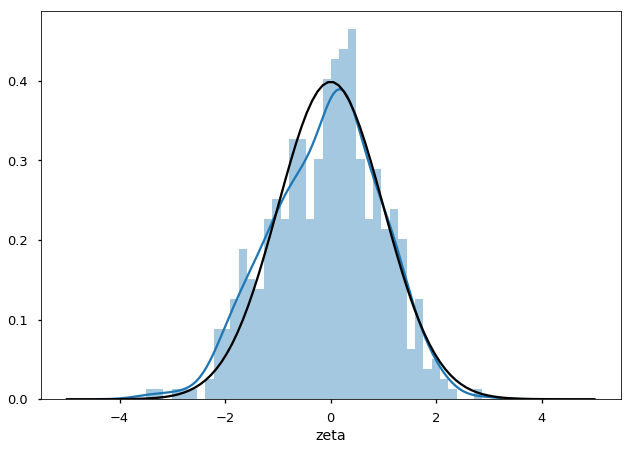

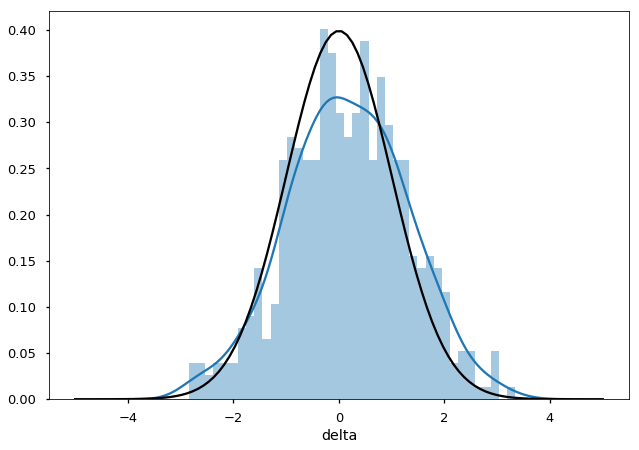

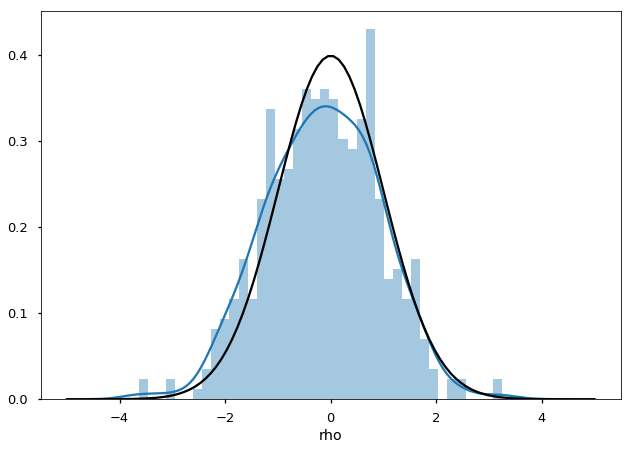

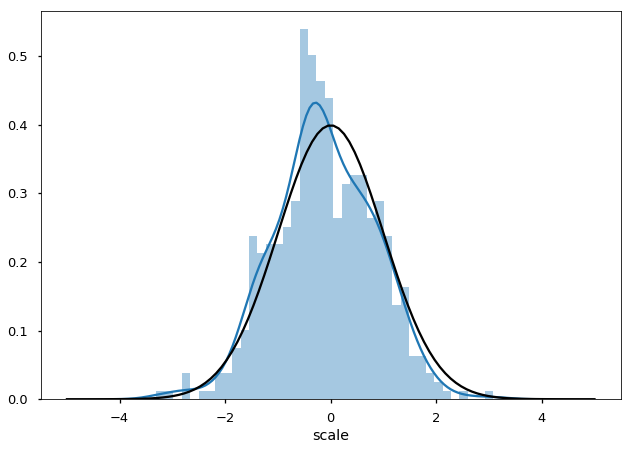

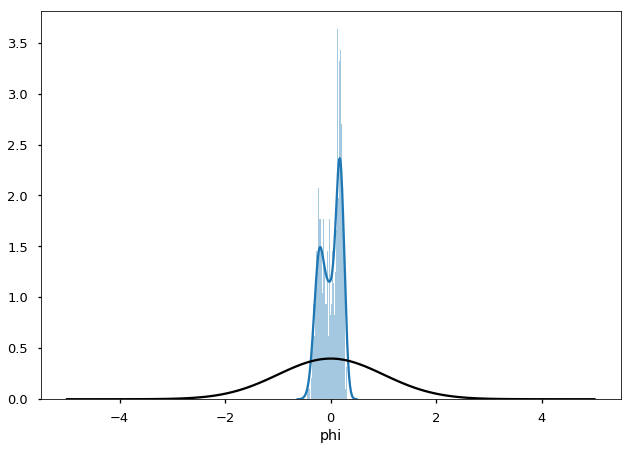

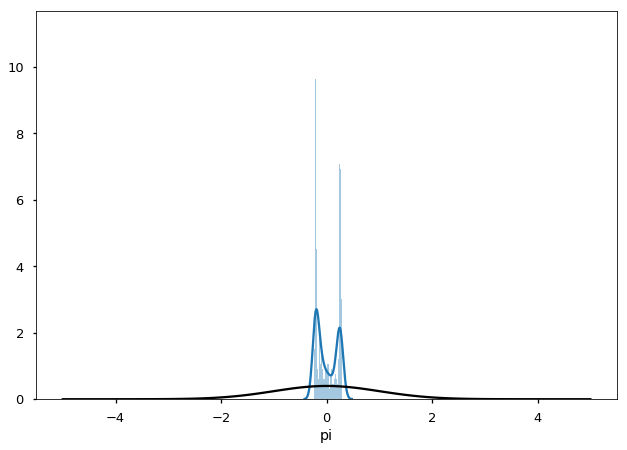

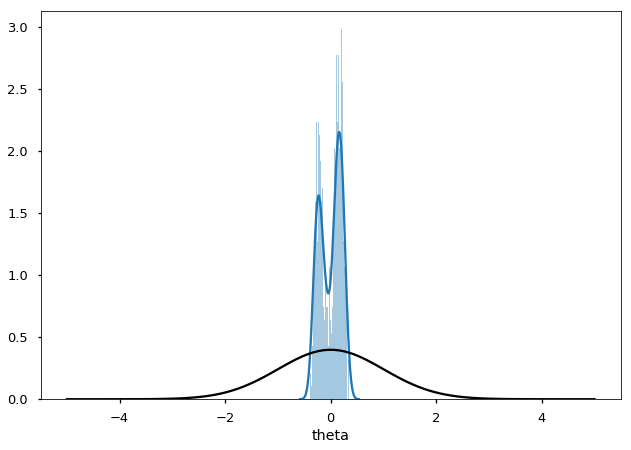

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

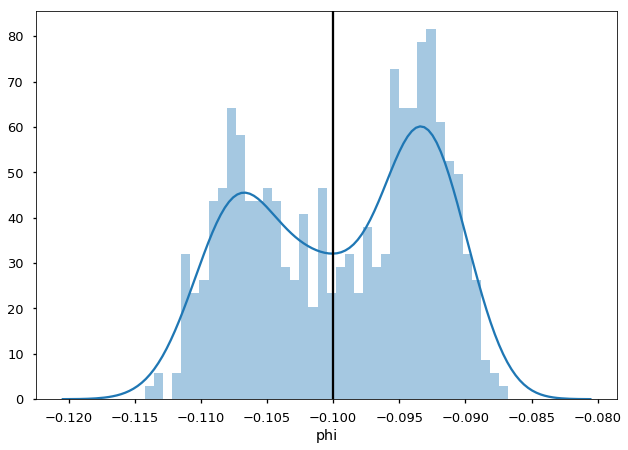

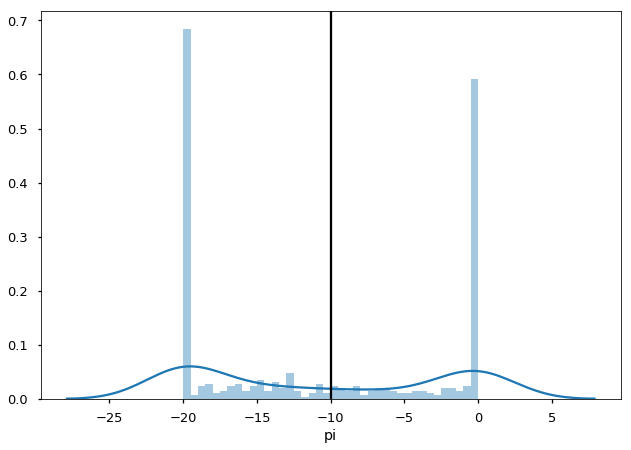

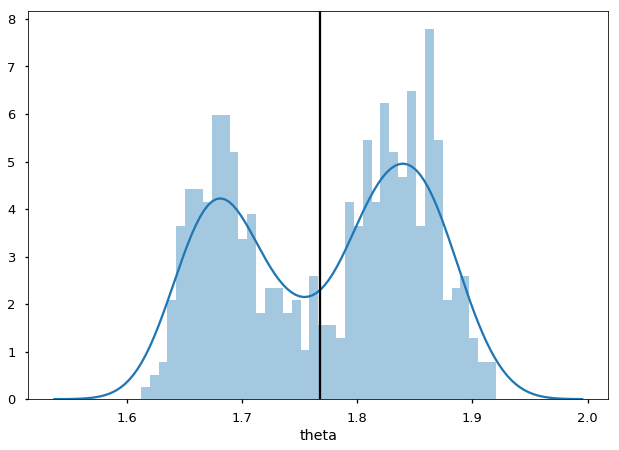

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        ax.axvline(total_true_params[name], color='black')
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega


{'gamma': 0.003092616914858787,
 'beta': 1.1837890442002412,
 'psi': -2.402751819864635,
 'zeta': 0.9999209141430664,
 'delta': 0.6187807155419934,
 'rho': 0.9556184364097029,
 'scale': 0.00388508502940008}

In [ ]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.1,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95}

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)